In [2]:
from mattergen.diffusion.diffusion_loss import *
from mattergen.common.data.chemgraph import *
import torch
import matplotlib.pyplot as plt
import json
from ase.io import read
import pandas as pd
from mattergen.common.data.chemgraph import ChemGraph
from mattergen.diffusion.diffusion_loss import environment_loss, energy_hull
import os
import glob
import numpy as np
from matplotlib.patches import Patch
import ast

torch.Size([8090, 10])


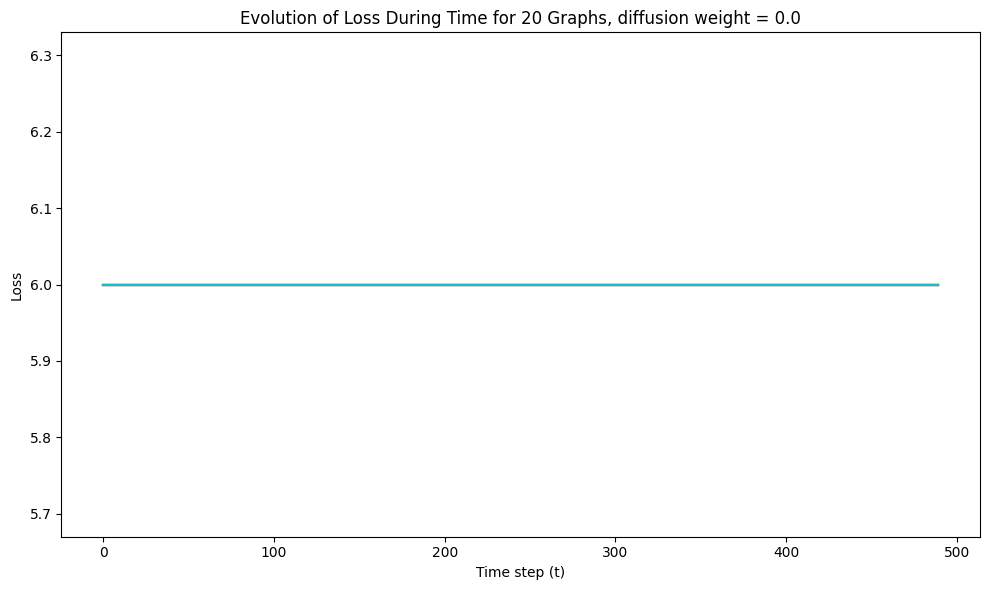

In [11]:
with open('/Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O_test/diffusion_loss_history.txt', 'r') as f:
    data = json.load(f)

# If the file contains a list of lists (matrix), convert to torch.Tensor or numpy array if needed
matrix2 = torch.tensor(data[1:])
print(matrix2.shape)

# Plot the first 20 rows of matrix as loss curves over time with log scale on y-axis
plt.figure(figsize=(10, 6))
for i in range(matrix2.shape[1]):
    plt.plot(matrix2[7600:,i].cpu().numpy(), label=f'Graph {i+1}')
plt.xlabel('Time step (t)')
plt.ylabel('Loss')
plt.title('Evolution of Loss During Time for 20 Graphs, diffusion weight = 0.0')
#plt.yscale('log')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

Found 2 files for X=3
Found 3 files for X=6


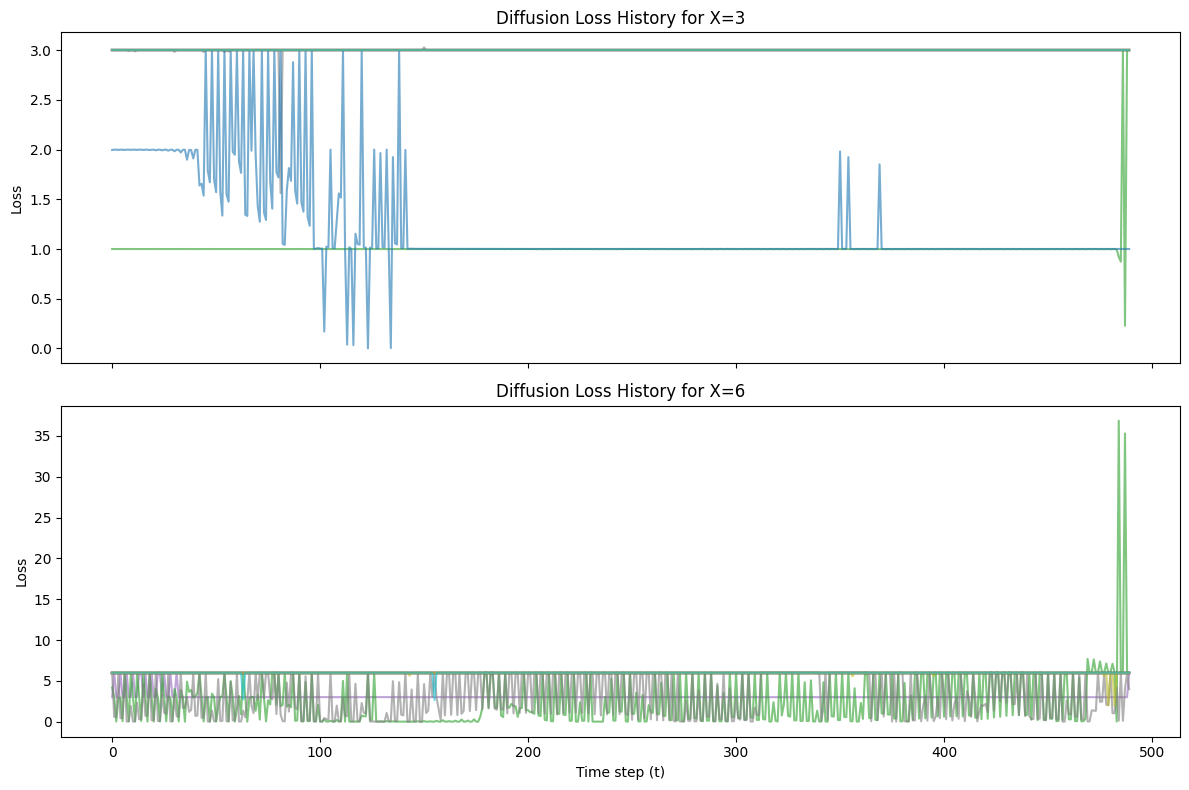

In [3]:
# Base directory
base_path = '/Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O_test'

# X values to group by
X_values = [3, 6]

# Prepare subplots: 2 rows, 1 column
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)

for idx, X in enumerate(X_values):
    ax = axes[idx]
    pattern = os.path.join(base_path, f'diffusion_loss_history_{X}_*.txt')
    files = sorted(glob.glob(pattern))

    print(f"Found {len(files)} files for X={X}")

    for file in files:
        with open(file, 'r') as f:
            data = json.load(f)

        matrix = torch.tensor(data[1:])
        if matrix.ndim != 2:
            print(f"Skipping {file}, unexpected shape: {matrix.shape}")
            continue

        for i in range(matrix.shape[1]):
            ax.plot(matrix[7600:, i].cpu().numpy(), label=f'Graph {i+1}', alpha=0.6)

    ax.set_title(f'Diffusion Loss History for X={X}')
    ax.set_ylabel('Loss')
    # ax.set_yscale('log')  # Uncomment if you want log scale

axes[-1].set_xlabel('Time step (t)')
plt.tight_layout()
# plt.legend()  # Optional: enable if not too crowded
plt.show()

torch.Size([3596, 100])


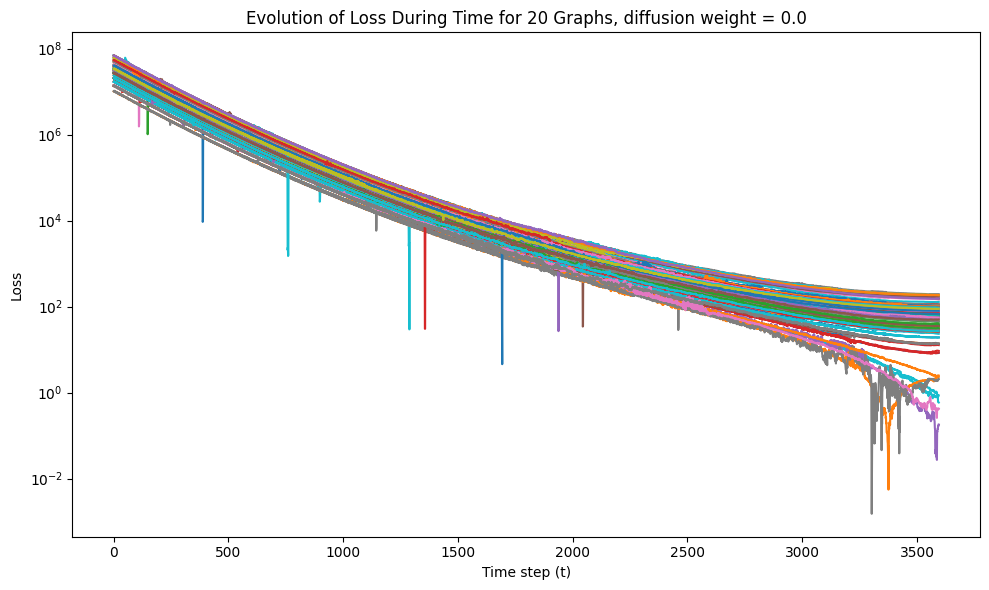

In [8]:
with open('/Data/auguste.de-lambilly/mattergenbis/results/chemical_system/Pd-Ni-H_guided/diffusion_loss_history.txt', 'r') as f:
    data = json.load(f)

# If the file contains a list of lists (matrix), convert to torch.Tensor or numpy array if needed
matrix2 = torch.tensor(data)
print(matrix2.shape)

# Plot the first 20 rows of matrix as loss curves over time with log scale on y-axis
plt.figure(figsize=(10, 6))
for i in range(matrix2.shape[1]):
    plt.plot(10**5*matrix2[:,i].cpu().numpy(), label=f'Graph {i+1}')
plt.xlabel('Time step (t)')
plt.ylabel('Loss')
plt.title('Evolution of Loss During Time for 20 Graphs, diffusion weight = 0.0')
plt.yscale('log')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

In [4]:
def compute_volumes_extxyz_file(extxyz_file):
    volumes = []
    # Read all frames from the extxyz file
    atoms_list = read(extxyz_file, index=':')
    for atoms in atoms_list:
        volumes.append(atoms.get_volume())
    return volumes


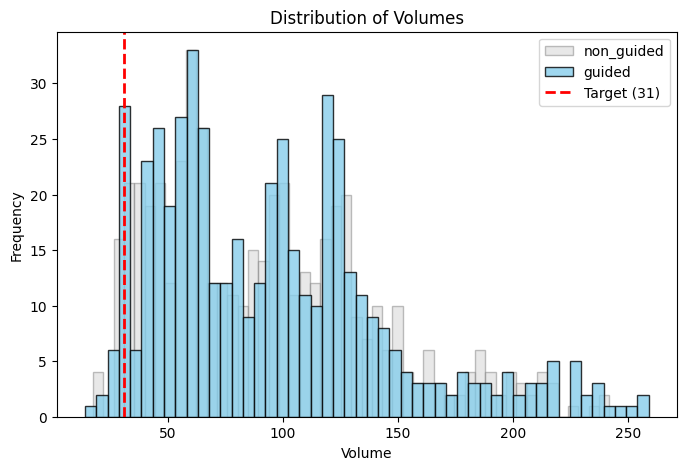

In [3]:
# Paths the extxyz files
extxyz_file_non_guided = r"/Data/auguste.de-lambilly/mattergenbis/results/chemical_system/Pd-Ni-H_non_guided/generated_crystals.extxyz"
extxyz_file_with_target = r"/Data/auguste.de-lambilly/mattergenbis/results/chemical_system/Pd-Ni-H_guided/generated_crystals.extxyz"

# Compute volumes for both sets
volumes_non_guided = compute_volumes_extxyz_file(extxyz_file_non_guided)
volumes_with_target = compute_volumes_extxyz_file(extxyz_file_with_target)

plt.figure(figsize=(8, 5))
# Plot "non_guided" as background
plt.hist(volumes_non_guided, bins=50, color='lightgray', edgecolor='gray', alpha=0.5, label='non_guided')
# Plot "with target" on top
plt.hist(volumes_with_target, bins=50, color='skyblue', edgecolor='black', alpha=0.8, label='guided')
plt.axvline(31, color='red', linestyle='--', linewidth=2, label='Target (31)')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.title('Distribution of Volumes')
plt.legend()
plt.show()

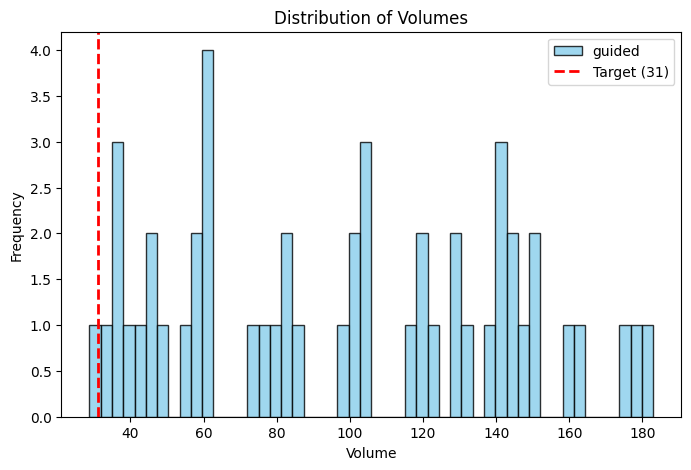

In [5]:
# Paths the extxyz files
#extxyz_file_non_guided = r"/Data/auguste.de-lambilly/mattergenbis/results/chemical_system/Pd-Ni-H_non_guided/generated_crystals.extxyz"
extxyz_file_with_target = r"/Data/auguste.de-lambilly/mattergenbis/results/chemical_system/Pd-Ni-H_guided/generated_crystals.extxyz"

# Compute volumes for both sets
#volumes_non_guided = compute_volumes_extxyz_file(extxyz_file_non_guided)
volumes_with_target = compute_volumes_extxyz_file(extxyz_file_with_target)

plt.figure(figsize=(8, 5))
# Plot "non_guided" as background
#plt.hist(volumes_non_guided, bins=50, color='lightgray', edgecolor='gray', alpha=0.5, label='non_guided')
# Plot "with target" on top
plt.hist(volumes_with_target, bins=50, color='skyblue', edgecolor='black', alpha=0.8, label='guided')
plt.axvline(31, color='red', linestyle='--', linewidth=2, label='Target (31)')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.title('Distribution of Volumes')
plt.legend()
plt.show()

In [6]:
extxyz_file = "/Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O_non_guided/generated_crystals.extxyz"
output_csv = "/Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O_non_guided/environment_loss_Co-O.csv"

# Atomic numbers for Co and O
co_Z = Element("Co").Z
o_Z = Element("O").Z
pair_str = "Co-O"

atoms_list = read(extxyz_file, index=':')

results = []
for idx, atoms in enumerate(atoms_list):
    atomic_numbers = atoms.get_atomic_numbers()
    if co_Z in atomic_numbers and o_Z in atomic_numbers:
        cell = torch.tensor(atoms.cell, dtype=torch.float32)
        pos = torch.tensor(atoms.get_scaled_positions(), dtype=torch.float32, requires_grad=True)
        chemgraph = ChemGraph(cell=cell, atomic_numbers=torch.tensor(atomic_numbers), pos=pos)
        target = {pair_str: 0.0}  # Dummy target, not used for value, just to trigger computation
        loss = int(environment_loss(chemgraph, None, target, alpha=800.0).item())
    else:
        loss = 0.0
    results.append({
        "structure_idx": idx,
        "Co-O_environment_loss": loss
    })

df = pd.DataFrame(results)
df.to_csv(output_csv, index=False)
print(f"Saved Co-O environment losses to {output_csv}")

Saved Co-O environment losses to /Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O_non_guided/environment_loss_Co-O.csv


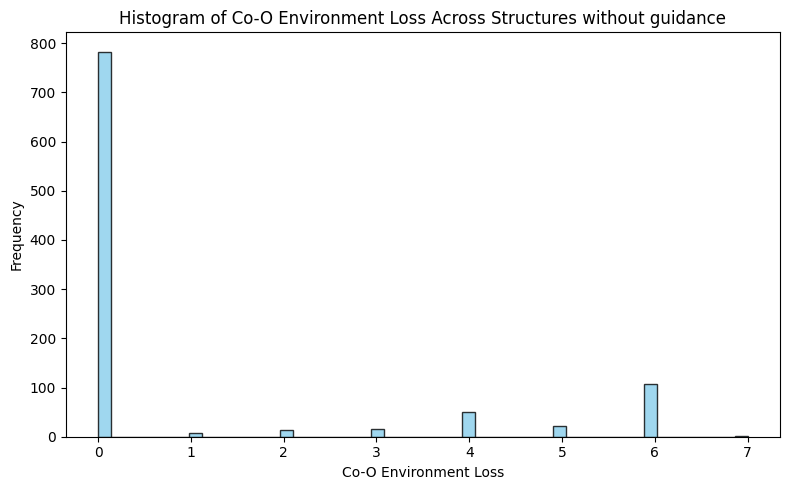

In [7]:
plt.figure(figsize=(8, 5))
plt.hist(df['Co-O_environment_loss'], bins=50, color='skyblue', edgecolor='black', alpha=0.8)
plt.xlabel('Co-O Environment Loss')
plt.ylabel('Frequency')
plt.title('Histogram of Co-O Environment Loss Across Structures without guidance')
plt.tight_layout()
plt.show()


In [8]:
extxyz_file = "/Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O_guided_env_3-2/generated_crystals.extxyz"
output_csv = "/Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O_guided_env_3-2/environment_loss_Co-O.csv"

# Atomic numbers for Co and O
co_Z = Element("Co").Z
o_Z = Element("O").Z
pair_str = "Co-O"

atoms_list = read(extxyz_file, index=':')

results_ = []
for idx, atoms in enumerate(atoms_list):
    atomic_numbers = atoms.get_atomic_numbers()
    if co_Z in atomic_numbers and o_Z in atomic_numbers:
        cell = torch.tensor(atoms.cell, dtype=torch.float32)
        pos = torch.tensor(atoms.get_scaled_positions(), dtype=torch.float32, requires_grad=True)
        chemgraph = ChemGraph(cell=cell, atomic_numbers=torch.tensor(atomic_numbers), pos=pos)
        target = {pair_str: 0.0}  # Dummy target, not used for value, just to trigger computation
        loss = int(environment_loss(chemgraph, None, target, alpha=800.0).item())
    else:
        loss = 0.0
    results_.append({
        "structure_idx": idx,
        "Co-O_environment_loss": loss
    })

df_ = pd.DataFrame(results_)
df_.to_csv(output_csv, index=False)
print(f"Saved Co-O environment losses to {output_csv}")

Saved Co-O environment losses to /Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O_guided_env_3-2/environment_loss_Co-O.csv


In [50]:
# Define the directories containing the CSV files
dir1 = "/Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O/environment_loss_Co-O_guided_env3_3-2.csv"
dir2 = "/Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O/environment_loss_Co-O_non_guided.csv"

# Read into DataFrames
df = pd.read_csv(dir1)
df_ = pd.read_csv(dir2)

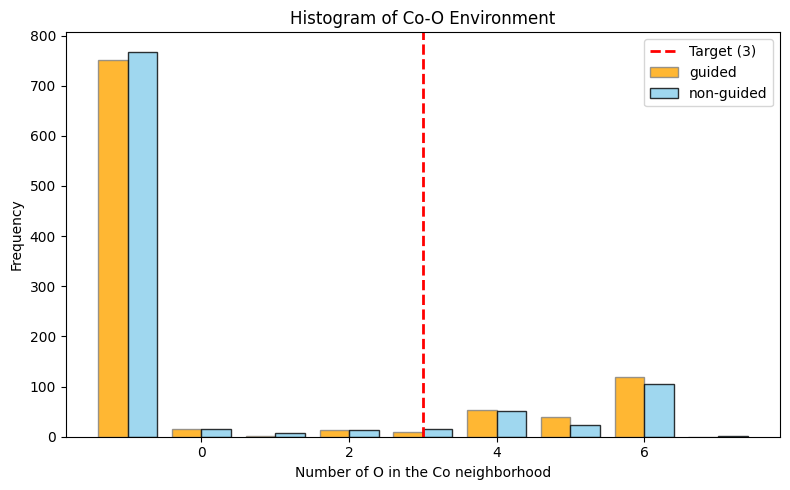

In [53]:
# Define integer bin centers
bin_centers = np.arange(
    min(df['Co-O_environment_loss'].min(), df_['Co-O_environment_loss'].min()),
    max(df['Co-O_environment_loss'].max(), df_['Co-O_environment_loss'].max()) + 1
)

# Shift for side-by-side bars
width = 0.4
left_bins = bin_centers - width/2
right_bins = bin_centers + width/2

plt.figure(figsize=(8, 5))
plt.bar(left_bins, np.histogram(df['Co-O_environment_loss'], bins=np.append(bin_centers-0.5, bin_centers[-1]+0.5))[0],
        width=width, color='orange', edgecolor='gray', alpha=0.8, label='guided', align='center')
plt.bar(right_bins, np.histogram(df_['Co-O_environment_loss'], bins=np.append(bin_centers-0.5, bin_centers[-1]+0.5))[0],
        width=width, color='skyblue', edgecolor='black', alpha=0.8, label='non-guided', align='center')
plt.axvline(3, color='red', linestyle='--', linewidth=2, label='Target (3)')
plt.xlabel('Number of O in the Co neighborhood')
plt.ylabel('Frequency')
plt.title('Histogram of Co-O Environment')
plt.legend()
plt.tight_layout()
plt.show()


In [2]:
# Directory containing the extxyz files
base_dir = "/Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O"
extxyz_files = glob.glob(os.path.join(base_dir, "**", "generated_crystals*.extxyz"), recursive=True)

# Atomic numbers for Co and O
co_Z = Element("Co").Z
o_Z = Element("O").Z
pair_str = "Co-O"

for extxyz_file in extxyz_files:
    # Build output CSV file name
    ext_dir = os.path.dirname(extxyz_file)
    ext_base = os.path.basename(extxyz_file)
    # Replace 'generated_crystals' with 'environment_loss_Co-O' and change extension to .csv
    csv_name = ext_base.replace("generated_crystals", "environment_loss_Co-O").replace(".extxyz", ".csv")
    output_csv = os.path.join(ext_dir, csv_name)

    # If CSV already exists, skip
    if os.path.exists(output_csv):
        print(f"Skipping {output_csv} (already exists)")
        continue

    atoms_list = read(extxyz_file, index=':')
    results = []
    for idx, atoms in enumerate(atoms_list):
        atomic_numbers = atoms.get_atomic_numbers()
        if co_Z in atomic_numbers and o_Z in atomic_numbers:
            atoms.cell = atoms.cell + np.eye(3) * 1e-8 
            cell = torch.tensor(atoms.cell, dtype=torch.float32)
            pos = torch.tensor(atoms.get_scaled_positions(), dtype=torch.float32, requires_grad=True)
            chemgraph = ChemGraph(cell=cell, atomic_numbers=torch.tensor(atomic_numbers), num_atoms=torch.tensor([atomic_numbers.size]), pos=pos)
            target = {pair_str: 0.0, "mode":"l1"}  # 0 target, to compute the actual number of neighbors
            loss = int(environment_loss(chemgraph, None, target, alpha = 100).item())
        else:
            loss = -1.0  # Use -1.0 to indicate no Co-O environment
        results.append({
            "structure_idx": idx,
            "Co-O_environment_loss": loss
        })

    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)
    print(f"Saved Co-O environment losses to {output_csv}")

Skipping /Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O/environment_loss_Co-O_non_guided.csv (already exists)
Skipping /Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O/environment_loss_Co-O_guided_env3_3-0.csv (already exists)
Skipping /Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O/environment_loss_Co-O_guided2_env6_3-4_huber_gpu0.csv (already exists)
Skipping /Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O/environment_loss_Co-O_test_0.csv (already exists)
Skipping /Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O/environment_loss_Co-O_guided_env6_g500.0_3-2_huber_gpu0.csv (already exists)


/tmp/ipykernel_1561456/3028823384.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  cell = torch.tensor(atoms.cell, dtype=torch.float32)


Saved Co-O environment losses to /Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O/environment_loss_Co-O_guided_3-2_huber_gpu0.csv
Saved Co-O environment losses to /Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O/environment_loss_Co-O_guided2_env6_3-2_huber_gpu9.csv
Saved Co-O environment losses to /Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O/environment_loss_Co-O_guided2_env3_g10.0_3-2_huber_gpu3.csv
Skipping /Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O/environment_loss_Co-O_guided2_env6_g500.0_3-2_huber_gpu0.csv (already exists)
Saved Co-O environment losses to /Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O/environment_loss_Co-O_guided2_env6_g0.01_3-2_huber_gpu0.csv
Saved Co-O environment losses to /Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O/environment_loss_Co-O_guided_env3_g10.0_3-2_huber_gpu6.csv
Skipping /Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O/environment_loss_Co-O_guided2_env3_3-2_real+.csv (already exists)
Skippin

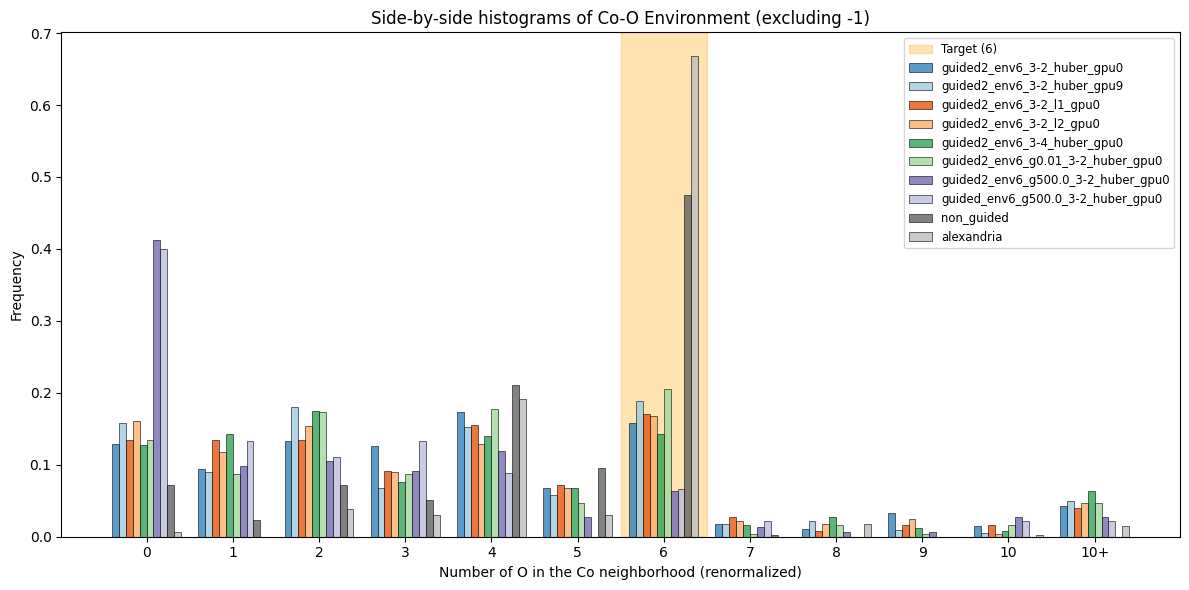

In [3]:
# Directory containing the CSV files
base_dir = "/Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O"
csv_files = sorted(glob.glob(os.path.join(base_dir, "**", "environment_loss_Co-O_guided*_env6*.csv"), recursive=True))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_non_guided.csv"))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_alexandria.csv"))

# Collect all integer values present in all files to define common bins, excluding -1
all_values = []
dfs = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    df_filtered = df[df['Co-O_environment_loss'] != -1].copy()
    # Cap values >10 to 11 (which will represent "10+")
    df_filtered['Co-O_environment_loss'] = df_filtered['Co-O_environment_loss'].clip(upper=11)
    dfs.append(df_filtered)
    all_values.extend(df_filtered['Co-O_environment_loss'].astype(int).tolist())
all_values = np.array(all_values)
min_val = all_values.min()
max_val = all_values.max()
bin_centers = np.arange(min_val, max_val + 1)
cmap = plt.get_cmap('tab20c')

# Prepare width and offsets for side-by-side bars
n_files = len(csv_files)
width = 0.8 / n_files
offsets = np.linspace(-0.4 + width/2, 0.4 - width/2, n_files)

plt.figure(figsize=(12, 6))

# Highlight the target value (6) with a vertical strip
target = 6
if target in bin_centers:
    plt.axvspan(target - 0.5, target + 0.5, color='orange', alpha=0.3, zorder=0, label='Target (6)')

for i, (csv_file, df_filtered) in enumerate(zip(csv_files, dfs)):
    color = cmap(i / max(n_files, 1))
    counts, _ = np.histogram(df_filtered['Co-O_environment_loss'], bins=np.append(bin_centers-0.5, bin_centers[-1]+0.5))
    total = counts.sum()
    if total > 0:
        counts = counts / total  # Normalize
    base = os.path.basename(csv_file)
    label = base.replace("environment_loss_Co-O_", "").replace(".csv", "")
    plt.bar(bin_centers + offsets[i], counts, width=width, label=label, align='center', edgecolor='black', linewidth=0.5, color=color, alpha=0.8)

plt.xlabel('Number of O in the Co neighborhood (renormalized)')
plt.ylabel('Frequency')
plt.title('Side-by-side histograms of Co-O Environment (excluding -1)')
plt.xticks(bin_centers, [str(x) if x < 11 else "10+" for x in bin_centers])
plt.legend(fontsize='small', loc='upper right')
plt.tight_layout()
plt.show()


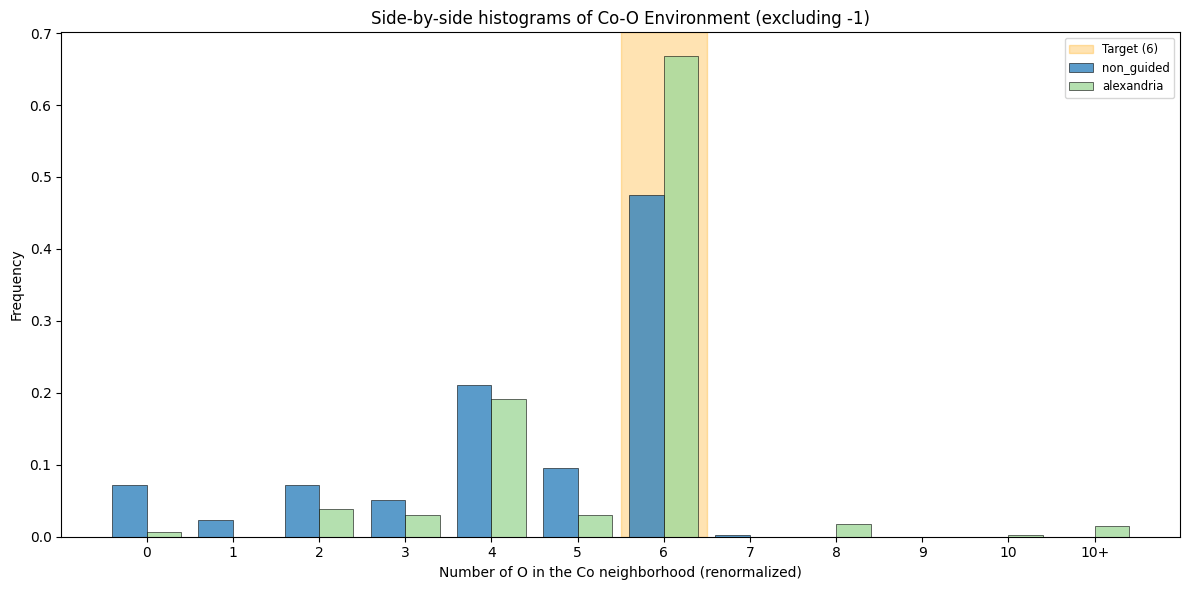

In [3]:
# Directory containing the CSV files
base_dir = "/Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O"
csv_files = []#sorted(glob.glob(os.path.join(base_dir, "**", "environment_loss_Co-O_guided*_env6*.csv"), recursive=True))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_non_guided.csv"))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_alexandria.csv"))

# Collect all integer values present in all files to define common bins, excluding -1
all_values = []
dfs = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    df_filtered = df[df['Co-O_environment_loss'] != -1].copy()
    # Cap values >10 to 11 (which will represent "10+")
    df_filtered['Co-O_environment_loss'] = df_filtered['Co-O_environment_loss'].clip(upper=11)
    dfs.append(df_filtered)
    all_values.extend(df_filtered['Co-O_environment_loss'].astype(int).tolist())
all_values = np.array(all_values)
min_val = all_values.min()
max_val = all_values.max()
bin_centers = np.arange(min_val, max_val + 1)
cmap = plt.get_cmap('tab20c')

# Prepare width and offsets for side-by-side bars
n_files = len(csv_files)
width = 0.8 / n_files
offsets = np.linspace(-0.4 + width/2, 0.4 - width/2, n_files)

plt.figure(figsize=(12, 6))

# Highlight the target value (6) with a vertical strip
target = 6
if target in bin_centers:
    plt.axvspan(target - 0.5, target + 0.5, color='orange', alpha=0.3, zorder=0, label='Target (6)')

for i, (csv_file, df_filtered) in enumerate(zip(csv_files, dfs)):
    color = cmap(i / max(n_files, 1))
    counts, _ = np.histogram(df_filtered['Co-O_environment_loss'], bins=np.append(bin_centers-0.5, bin_centers[-1]+0.5))
    total = counts.sum()
    if total > 0:
        counts = counts / total  # Normalize
    base = os.path.basename(csv_file)
    label = base.replace("environment_loss_Co-O_", "").replace(".csv", "")
    plt.bar(bin_centers + offsets[i], counts, width=width, label=label, align='center', edgecolor='black', linewidth=0.5, color=color, alpha=0.8)

plt.xlabel('Number of O in the Co neighborhood (renormalized)')
plt.ylabel('Frequency')
plt.title('Side-by-side histograms of Co-O Environment (excluding -1)')
plt.xticks(bin_centers, [str(x) if x < 11 else "10+" for x in bin_centers])
plt.legend(fontsize='small', loc='upper right')
plt.tight_layout()
plt.show()


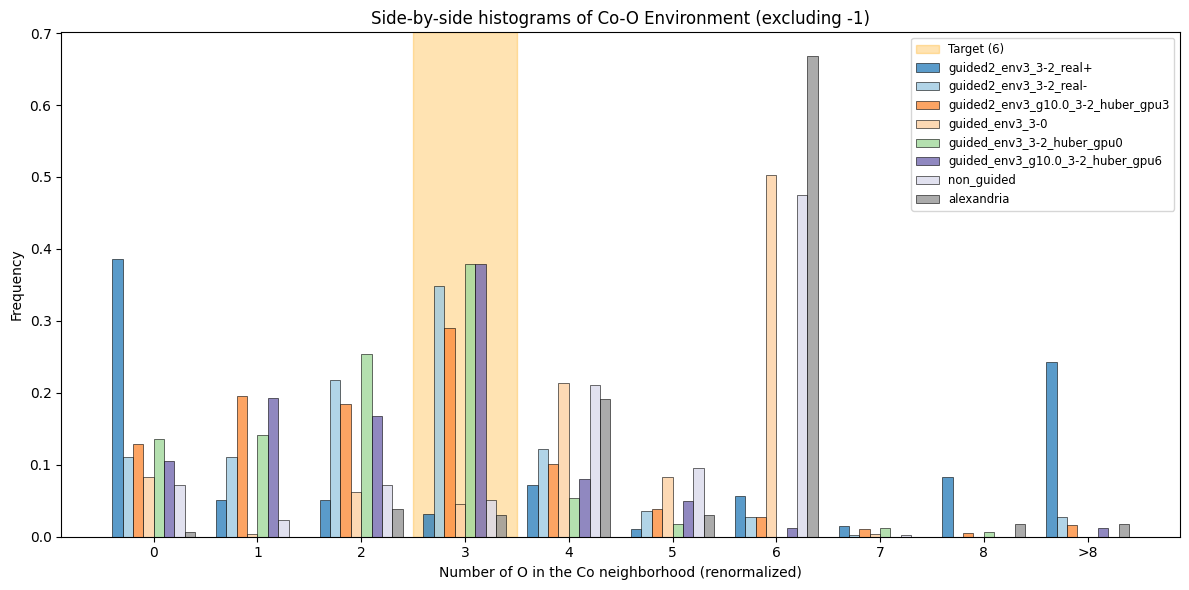

In [4]:
# Directory containing the CSV files
base_dir = "/Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O"
csv_files = sorted(glob.glob(os.path.join(base_dir, "**", "environment_loss_Co-O_guided*_env3*.csv"), recursive=True))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_non_guided.csv"))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_alexandria.csv"))

# Collect all integer values present in all files to define common bins, excluding -1
all_values = []
dfs = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    df_filtered = df[df['Co-O_environment_loss'] != -1].copy()
    # Cap values >10 to 11 (which will represent "10+")
    df_filtered['Co-O_environment_loss'] = df_filtered['Co-O_environment_loss'].clip(upper=9)
    dfs.append(df_filtered)
    all_values.extend(df_filtered['Co-O_environment_loss'].astype(int).tolist())
all_values = np.array(all_values)
min_val = all_values.min()
max_val = all_values.max()
bin_centers = np.arange(min_val, max_val + 1)
cmap = plt.get_cmap('tab20c')

# Prepare width and offsets for side-by-side bars
n_files = len(csv_files)
width = 0.8 / n_files
offsets = np.linspace(-0.4 + width/2, 0.4 - width/2, n_files)

plt.figure(figsize=(12, 6))

# Highlight the target value (6) with a vertical strip
target = 3
if target in bin_centers:
    plt.axvspan(target - 0.5, target + 0.5, color='orange', alpha=0.3, zorder=0, label='Target (6)')

for i, (csv_file, df_filtered) in enumerate(zip(csv_files, dfs)):
    color = cmap(i / max(n_files, 1))
    counts, _ = np.histogram(df_filtered['Co-O_environment_loss'], bins=np.append(bin_centers-0.5, bin_centers[-1]+0.5))
    total = counts.sum()
    if total > 0:
        counts = counts / total  # Normalize so sum = 1000
    base = os.path.basename(csv_file)
    label = base.replace("environment_loss_Co-O_", "").replace(".csv", "")
    plt.bar(bin_centers + offsets[i], counts, width=width, label=label, align='center', edgecolor='black', linewidth=0.5, color=color, alpha=0.8)

plt.xlabel('Number of O in the Co neighborhood (renormalized)')
plt.ylabel('Frequency')
plt.title('Side-by-side histograms of Co-O Environment (excluding -1)')
plt.xticks(bin_centers, [str(x) if x < 9 else ">8" for x in bin_centers])
plt.legend(fontsize='small', loc='upper right')
plt.tight_layout()
plt.show()


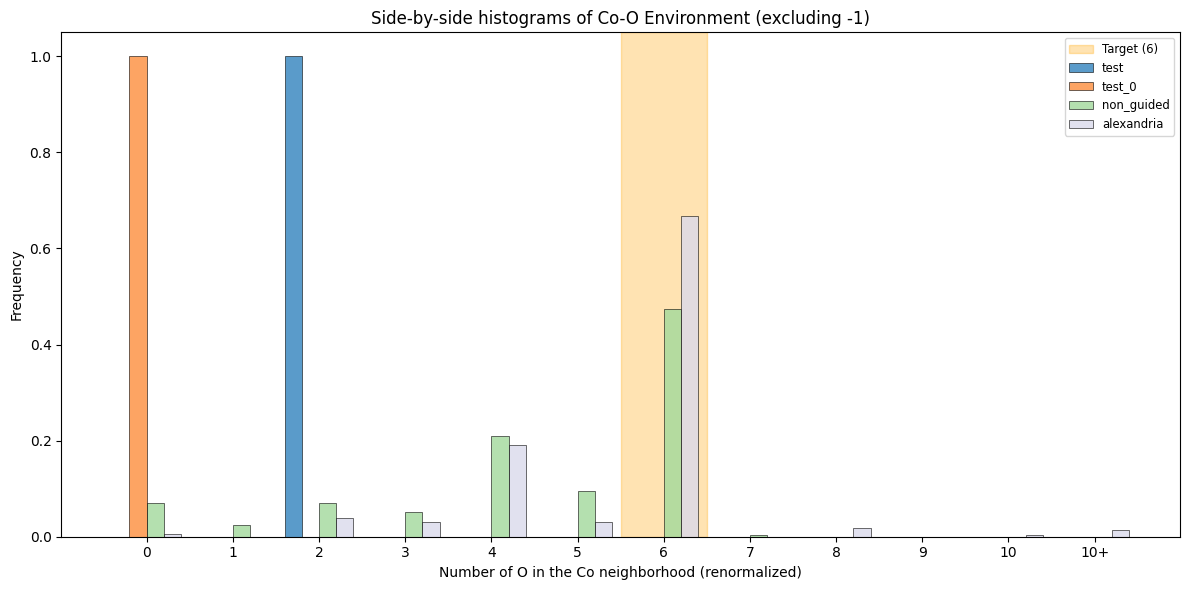

In [9]:
# Directory containing the CSV files
base_dir = "/Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O"
csv_files = sorted(glob.glob(os.path.join(base_dir, "**", "environment_loss_Co-O_test*.csv"), recursive=True))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_non_guided.csv"))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_alexandria.csv"))

# Collect all integer values present in all files to define common bins, excluding -1
all_values = []
dfs = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    df_filtered = df[df['Co-O_environment_loss'] != -1].copy()
    # Cap values >10 to 11 (which will represent "10+")
    df_filtered['Co-O_environment_loss'] = df_filtered['Co-O_environment_loss'].clip(upper=11)
    dfs.append(df_filtered)
    all_values.extend(df_filtered['Co-O_environment_loss'].astype(int).tolist())
all_values = np.array(all_values)
min_val = all_values.min()
max_val = all_values.max()
bin_centers = np.arange(min_val, max_val + 1)
cmap = plt.get_cmap('tab20c')

# Prepare width and offsets for side-by-side bars
n_files = len(csv_files)
width = 0.8 / n_files
offsets = np.linspace(-0.4 + width/2, 0.4 - width/2, n_files)

plt.figure(figsize=(12, 6))

# Highlight the target value (6) with a vertical strip
target = 6
if target in bin_centers:
    plt.axvspan(target - 0.5, target + 0.5, color='orange', alpha=0.3, zorder=0, label='Target (6)')

for i, (csv_file, df_filtered) in enumerate(zip(csv_files, dfs)):
    color = cmap(i / max(n_files, 1))
    counts, _ = np.histogram(df_filtered['Co-O_environment_loss'], bins=np.append(bin_centers-0.5, bin_centers[-1]+0.5))
    total = counts.sum()
    if total > 0:
        counts = counts / total  # Normalize
    base = os.path.basename(csv_file)
    label = base.replace("environment_loss_Co-O_", "").replace(".csv", "")
    plt.bar(bin_centers + offsets[i], counts, width=width, label=label, align='center', edgecolor='black', linewidth=0.5, color=color, alpha=0.8)

plt.xlabel('Number of O in the Co neighborhood (renormalized)')
plt.ylabel('Frequency')
plt.title('Side-by-side histograms of Co-O Environment (excluding -1)')
plt.xticks(bin_centers, [str(x) if x < 11 else "10+" for x in bin_centers])
plt.legend(fontsize='small', loc='upper right')
plt.tight_layout()
plt.show()


125; 117 : 
Mo Si B P : B-P (>=1 pas forcément chaque B)
Cu Si P : (Cu-P:4) 2.3 (2.28-2.5); (Cu-Cu: 0?) 3.7
Ba Cu P : 

Ex: BaCu2P4, Ba8Cu16P30

Cu Si P X : (Cu-P:4) 2.2-2.6; Cu-Cu : 0 en dessous de 2.9
X : Ba, Sr, Ca

proximité avec des positions "prototypes" (pas lié aux distances):
distances à Cr5B3, Mo2B4 et W5Si3

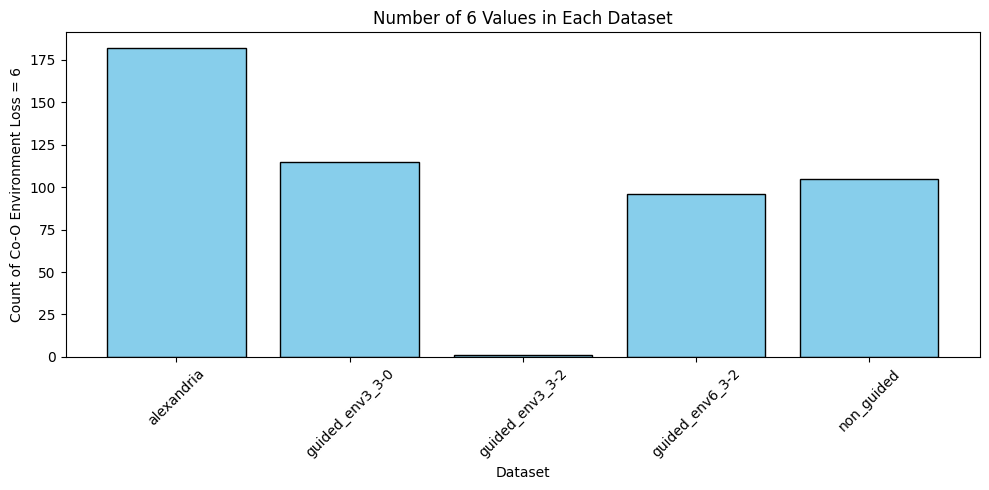

In [2]:
# Directory containing the CSV files
base_dir = "/Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O"
csv_files = sorted(glob.glob(os.path.join(base_dir, "**", "environment_loss_Co-O*.csv"), recursive=True))

labels = []
counts_6 = []

for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    count_6 = (df['Co-O_environment_loss'] == 6).sum()
    # Extract label from filename
    base = os.path.basename(csv_file)
    label = base.replace("environment_loss_Co-O_", "").replace(".csv", "")
    labels.append(label)
    counts_6.append(count_6)

plt.figure(figsize=(10, 5))
plt.bar(labels, counts_6, color='skyblue', edgecolor='black')
plt.xlabel('Dataset')
plt.ylabel('Count of Co-O Environment Loss = 6')
plt.title('Number of 6 Values in Each Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

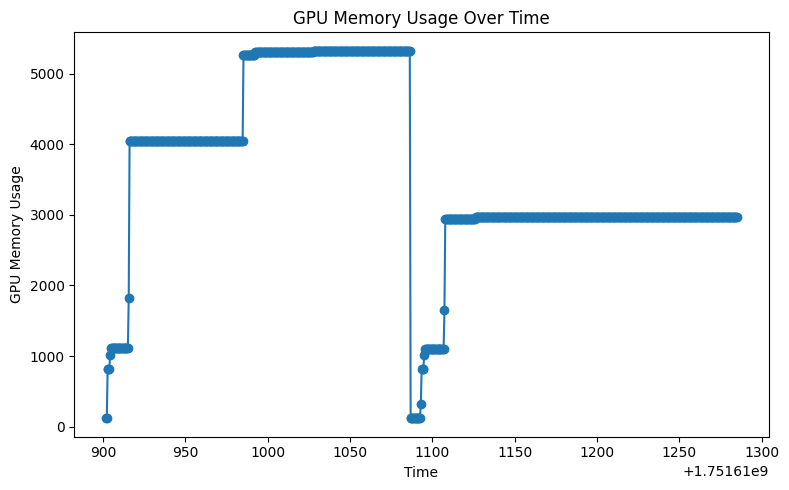

In [9]:
# Read and plot the values from log_gpu_mem.txt
log_file = "/Data/auguste.de-lambilly/mattergenbis/log_gpu_mem.txt"
times = []
values = []

with open(log_file) as f:
    for line in f:
        t, v = line.strip().split('\t')
        times.append(float(t))
        # v is like '[116]', '[4047]', etc.
        v_num = ast.literal_eval(v)[0]  # Safely parse the list and get the first value
        values.append(v_num)

plt.figure(figsize=(8, 5))
plt.plot(times, values, marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('GPU Memory Usage')
plt.title('GPU Memory Usage Over Time')
plt.tight_layout()
plt.show()